<a href="https://colab.research.google.com/github/bunnysocks/DAv2-Finetuning/blob/main/BaselineModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Install required packages
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib numpy
!pip install timm  # For vision transformers

CUDA available: True
GPU: Tesla T4


In [4]:
# Clone the Depth Anything v2 repository
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git
%cd Depth-Anything-V2

# Download pretrained weights (small model for Colab)
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth

# Add to Python path
import sys
sys.path.append('/content/Depth-Anything-V2')

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 142 (delta 31), reused 24 (delta 24), pack-reused 82 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/Depth-Anything-V2
--2025-11-10 13:10:38--  https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.34, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/666b17aaed1ed0f9bf42823e/01950a0198f6ece4acfd924dbc91f9f6bed4b614a222d64ad3c516ba39447464?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Credential=cas%2F20251110%2Fus-east-1%2Fs3%2Faws4_req

In [5]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.7 MB/s eta 0:00:00


In [6]:
from depth_anything_v2.dpt import DepthAnythingV2

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DepthAnythingV2(
    encoder='vits',  # Small version
    features=64,
    out_channels=[48, 96, 192, 384]
)

# Load pretrained weights
model.load_state_dict(torch.load('depth_anything_v2_vits.pth', map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [7]:
import cv2
import numpy as np
from PIL import Image

def load_image(image_path, target_size=518):
    """Load and preprocess image for model"""
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, model needs RGB

    # Resize
    h, w = img.shape[:2]
    img = cv2.resize(img, (target_size, target_size))

    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0

    return img, (h, w)  # Return original size for later

# Test it
image_path="/content/Depth-Anything-V2/assets/examples/demo01.jpg"
test_img, orig_size = load_image(image_path)
print(f"Preprocessed shape: {test_img.shape}")
print(f"Original size: {orig_size}")

Preprocessed shape: (518, 518, 3)
Original size: (1362, 2048)


In [8]:
def predict_depth(model, image):
    """Run model inference"""
    # Convert to tensor
    img_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    # Shape: (1, 3, 518, 518) = (batch, channels, height, width)

    img_tensor = img_tensor.to(device)

    # Predict
    with torch.no_grad():  # Disable gradient calculation (faster)
        depth = model(img_tensor)

    # Convert back to numpy
    depth = depth.squeeze().cpu().numpy()

    return depth

# Test prediction
depth_map = predict_depth(model, test_img)
print(f"Depth map shape: {depth_map.shape}")
print(f"Depth range: [{depth_map.min():.2f}, {depth_map.max():.2f}]")

Depth map shape: (518, 518)
Depth range: [0.00, 9.65]


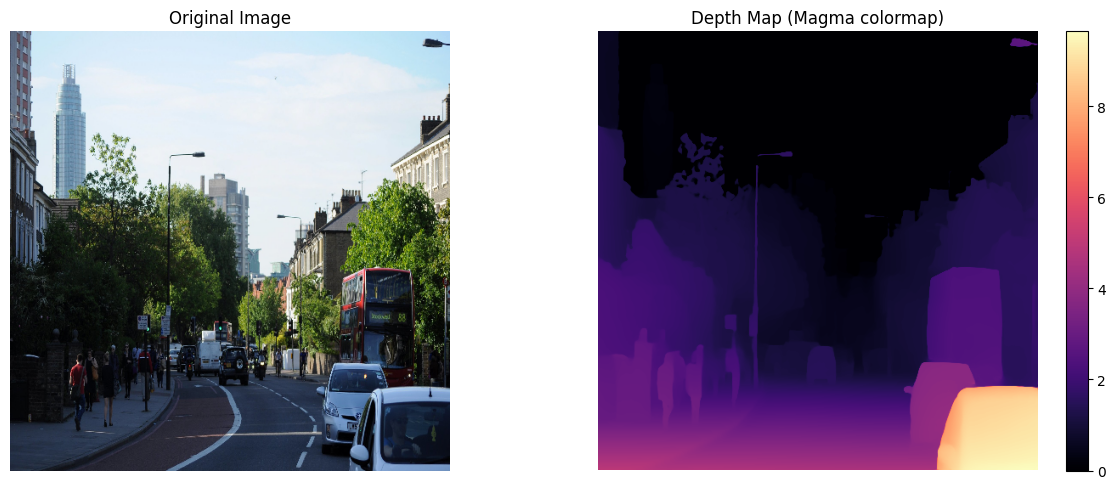

In [9]:
import matplotlib.pyplot as plt

def visualize_depth(image, depth):
    """Display original image and depth map side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Depth map (use colormap for better visualization)
    im = axes[1].imshow(depth, cmap='magma')
    axes[1].set_title('Depth Map (Magma colormap)')
    axes[1].axis('off')

    # Add colorbar
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    plt.tight_layout()
    plt.show()

# Visualize
visualize_depth(test_img, depth_map)


Testing: /content/drive/MyDrive/DAv2-Finetuning/regularroom.jpg


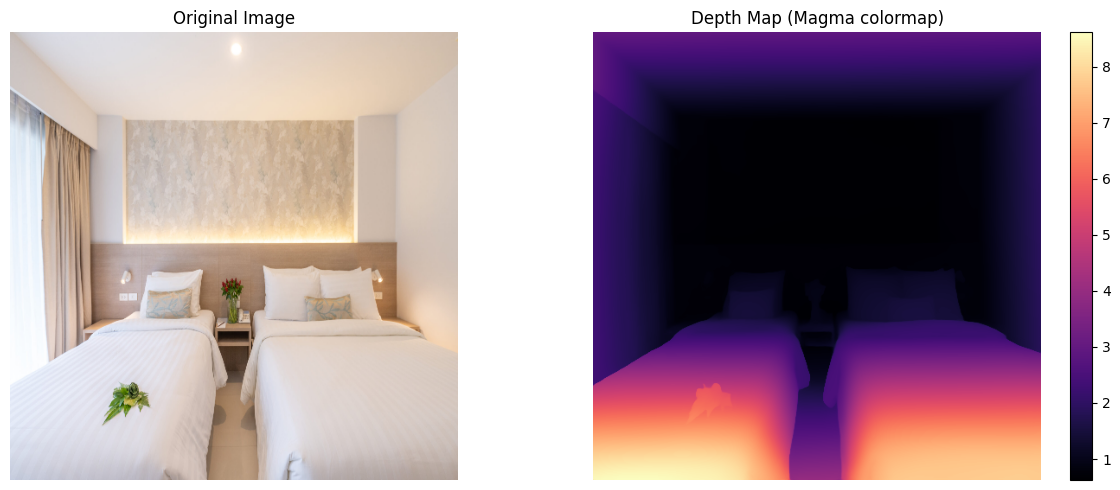


Testing: /content/drive/MyDrive/DAv2-Finetuning/glassdoors.jpeg


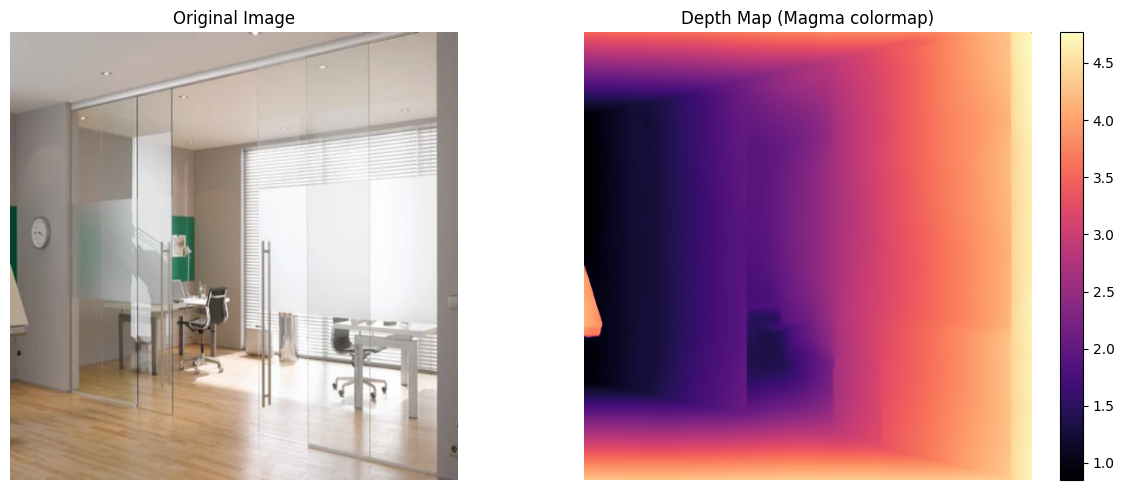


Testing: /content/drive/MyDrive/DAv2-Finetuning/mirrorbathroom.jpg


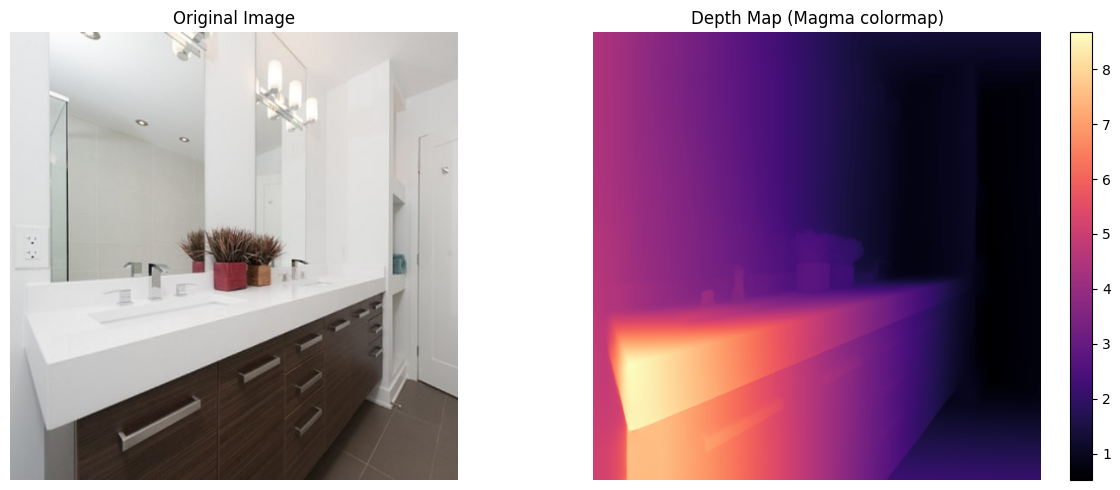

In [10]:
# Test on different scenarios
test_cases = [
    '/content/drive/MyDrive/DAv2-Finetuning/regularroom.jpg',
    '/content/drive/MyDrive/DAv2-Finetuning/glassdoors.jpeg',
    '/content/drive/MyDrive/DAv2-Finetuning/mirrorbathroom.jpg',
]

for img_path in test_cases:
    print(f"\n{'='*50}")
    print(f"Testing: {img_path}")
    print('='*50)

    img, _ = load_image(img_path)
    depth = predict_depth(model, img)
    visualize_depth(img, depth)

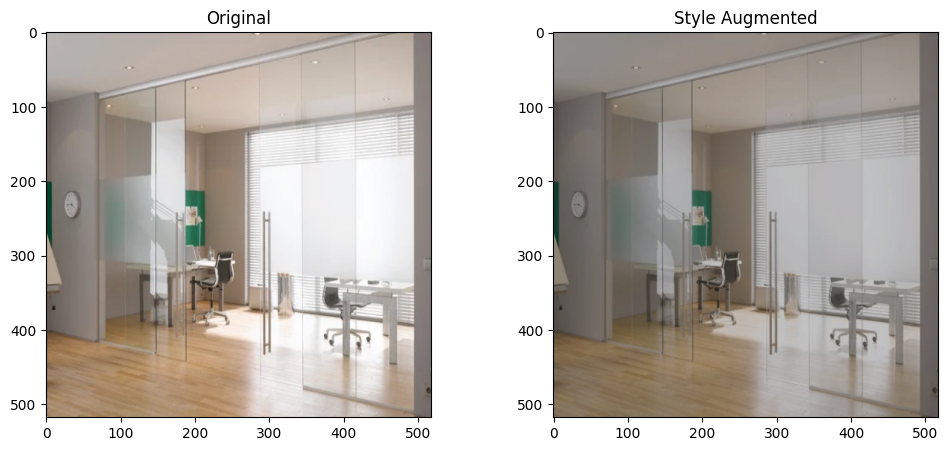

In [11]:
def apply_style_augmentation(image):
    """Apply random style changes while preserving geometry"""
    img = image.copy()

    # Random brightness adjustment
    brightness_factor = np.random.uniform(0.7, 1.3)
    img = np.clip(img * brightness_factor, 0, 1)

    # Random contrast adjustment
    contrast_factor = np.random.uniform(0.8, 1.2)
    mean = img.mean()
    img = np.clip((img - mean) * contrast_factor + mean, 0, 1)

    # Random hue shift (convert to HSV)
    img_hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hue_shift = np.random.randint(-10, 10)
    img_hsv[:, :, 0] = (img_hsv[:, :, 0].astype(int) + hue_shift) % 180
    img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0

    return img

# Test it
original_img, _ = load_image('/content/drive/MyDrive/DAv2-Finetuning/glassdoors.jpeg')
styled_img = apply_style_augmentation(original_img)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(original_img)
axes[0].set_title('Original')
axes[1].imshow(styled_img)
axes[1].set_title('Style Augmented')
plt.show()

Style Consistency Loss: 0.0613


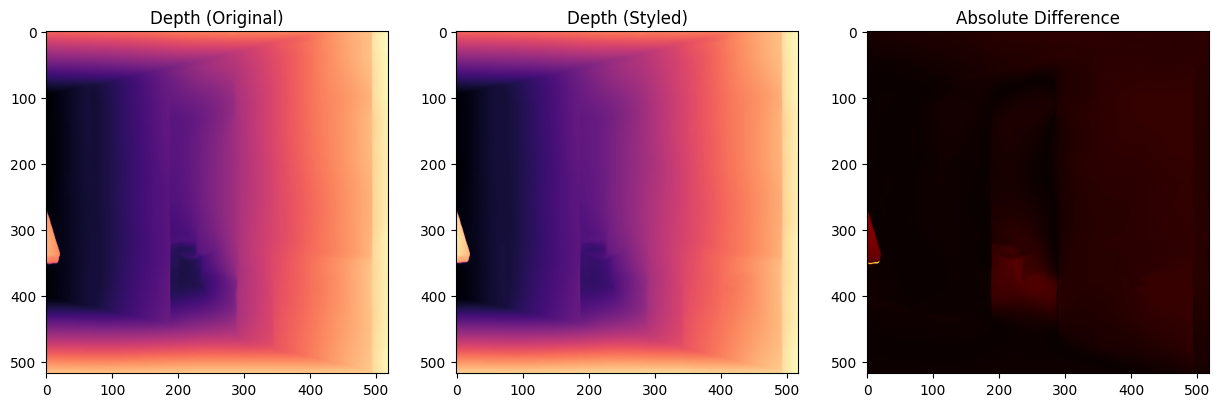

In [12]:
def style_consistency_loss(model, original_img, styled_img):
    """Compute L1 distance between depth predictions"""

    # Get depth for both images
    depth_original = predict_depth(model, original_img)
    depth_styled = predict_depth(model, styled_img)

    # Compute L1 loss (mean absolute difference)
    loss = np.abs(depth_original - depth_styled).mean()

    return loss, depth_original, depth_styled

# Test it
loss, d1, d2 = style_consistency_loss(model, original_img, styled_img)
print(f"Style Consistency Loss: {loss:.4f}")

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(d1, cmap='magma')
axes[0].set_title('Depth (Original)')
axes[1].imshow(d2, cmap='magma')
axes[1].set_title('Depth (Styled)')
axes[2].imshow(np.abs(d1 - d2), cmap='hot')
axes[2].set_title('Absolute Difference')
plt.show()

In [13]:
import torch
import torch.nn as nn

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DomainAdapter(nn.Module):
    """Lightweight adapter for domain adaptation"""

    def __init__(self, in_channels, reduction_ratio=4):
        super().__init__()

        # Bottleneck design: compress then expand
        hidden_dim = in_channels // reduction_ratio

        self.adapter = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1),  # 1x1 conv (compress)
            nn.GELU(),                              # Activation
            nn.Conv2d(hidden_dim, in_channels, 1),  # 1x1 conv (expand)
        )

        # Residual connection scaling
        self.scale = nn.Parameter(torch.ones(1) * 0.1)

    def forward(self, x):
        """Forward pass with residual connection"""
        adapted = self.adapter(x)
        return x + self.scale * adapted

In [14]:
adapter = DomainAdapter(in_channels=384).to(device)
dummy_features = torch.randn(1, 384, 32, 32).to(device)
output = adapter(dummy_features)

print(f"Input shape: {dummy_features.shape}")
print(f"Output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in adapter.parameters()):,}")

Input shape: torch.Size([1, 384, 32, 32])
Output shape: torch.Size([1, 384, 32, 32])
Parameters: 74,209


In [15]:
class AdaptedDepthModel(nn.Module):
    """DAv2 with domain adapter inserted"""

    def __init__(self, base_model):
        super().__init__()

        # Use pretrained encoder/decoder
        self.encoder = base_model.pretrained
        self.decoder = base_model.depth_head

        # Add adapter after encoder
        # (Adjust in_channels based on your model variant)
        self.adapter = DomainAdapter(in_channels=384)

        # Freeze encoder initially
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        """Forward pass through model"""
        # Encode
        features = self.encoder(x)

        # Apply adapter
        adapted_features = self.adapter(features[-1])  # Adapt last layer
        features[-1] = adapted_features

        # Decode
        depth = self.decoder(features)

        return depth

    def unfreeze_encoder_layers(self, num_layers=2):
        """Unfreeze last N encoder layers for fine-tuning"""
        encoder_layers = list(self.encoder.children())
        for layer in encoder_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

# Create adapted model
adapted_model = AdaptedDepthModel(model).to(device)

# Check trainable parameters
total_params = sum(p.numel() for p in adapted_model.parameters())
trainable_params = sum(p.numel() for p in adapted_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

Total parameters: 24,859,298
Trainable parameters: 2,802,722
Trainable %: 11.27%


In [16]:
def edge_aware_smoothness_loss(depth, image):
    """
    Penalize depth gradients unless there's an image edge

    Args:
        depth: (H, W) depth map
        image: (H, W, 3) RGB image
    """
    # Convert to tensors if needed
    if not isinstance(depth, torch.Tensor):
        depth = torch.from_numpy(depth).unsqueeze(0).unsqueeze(0)
    if not isinstance(image, torch.Tensor):
        image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

    depth = depth.to(device)
    image = image.to(device)

    # Compute depth gradients
    grad_depth_x = torch.abs(depth[:, :, :, :-1] - depth[:, :, :, 1:])
    grad_depth_y = torch.abs(depth[:, :, :-1, :] - depth[:, :, 1:, :])

    # Compute image gradients (edges)
    grad_img_x = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]), dim=1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]), dim=1, keepdim=True)

    # Weight depth gradients by inverse of image gradients
    # Large image gradient = edge = allow depth change = small weight
    weight_x = torch.exp(-grad_img_x)
    weight_y = torch.exp(-grad_img_y)

    # Smoothness loss
    loss_x = (grad_depth_x * weight_x).mean()
    loss_y = (grad_depth_y * weight_y).mean()

    return loss_x + loss_y

# Test it
smooth_loss = edge_aware_smoothness_loss(depth_map, test_img)
print(f"Smoothness loss: {smooth_loss:.4f}")

Smoothness loss: 0.0267


In [17]:
class DepthAdaptationLoss:
    """Combined loss for domain adaptation"""

    def __init__(self, lambda_style=1.0, lambda_smooth=0.1):
        self.lambda_style = lambda_style
        self.lambda_smooth = lambda_smooth

    def __call__(self, model, image_batch):
        """
        Compute total loss

        Args:
            model: Adapted depth model
            image_batch: (B, H, W, 3) batch of images
        """
        losses = {}

        # Process each image in batch
        total_loss = 0

        for img in image_batch:
            # 1. Style consistency loss
            styled_img = apply_style_augmentation(img)

            depth_orig = model(self.prepare_input(img))
            depth_styled = model(self.prepare_input(styled_img))

            style_loss = torch.abs(depth_orig - depth_styled).mean()
            losses['style'] = style_loss.item()

            # 2. Smoothness loss
            smooth_loss = edge_aware_smoothness_loss(depth_orig, img)
            losses['smooth'] = smooth_loss.item()

            # Combine
            total_loss += (self.lambda_style * style_loss +
                          self.lambda_smooth * smooth_loss)

        # Average over batch
        total_loss = total_loss / len(image_batch)
        losses['total'] = total_loss.item()

        return total_loss, losses

    @staticmethod
    def prepare_input(img):
        """Convert numpy image to tensor"""
        tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
        return tensor.to(device)

# Initialize loss
criterion = DepthAdaptationLoss(lambda_style=1.0, lambda_smooth=0.1)